In [19]:
import os
import math
import time
from pathlib import Path
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt



In [20]:
# SPEED CONFIG
torch.backends.cudnn.benchmark = True       #Fast CNN kernels
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

#PATH CONFIG
DATA_DIR = r"C:\Users\AL IMRAN\Downloads\archive\Dataset_Final_V2_Split"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

In [21]:
#TRAIN CONFIG
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 2          
PIN_MEMORY = True
PERSISTENT = True

NUM_CLASSES = 52
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
EPOCHS = 50
MODEL_OUT =  r"C:\Users\AL IMRAN\Desktop\cse499_data2\best_model.pth"


torch.manual_seed(SEED)


In [22]:
# FAST TRANSFORMS 
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


In [23]:
# LOAD DATASETS
train_ds = ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = ImageFolder(VAL_DIR, transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

print("DataLoader ready — GPU optimized")

DataLoader ready — GPU optimized


In [24]:
#  model definition (custom CNN)

#Custom CNN tuned to ~1.24M parameters
#conv channels: [48, 72, 120, 192, 256]
# adaptive avg pool -> FC(1536) -> FC(num_classes)
    


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, pool=True):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_c)
        self.act  = nn.ReLU(inplace=True)
        self.pool = pool
        if pool:
            self.pool_layer = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        if self.pool:
            x = self.pool_layer(x)
        return x

class LeafCNN(nn.Module):

    def __init__(self, num_classes=52):
        super().__init__()
        ch = [48, 72, 120, 192, 256]
        self.layer1 = ConvBlock(3,   ch[0], pool=True)   # out: 48 x 112 x 112
        self.layer2 = ConvBlock(ch[0], ch[1], pool=True) # 72 x 56 x 56
        self.layer3 = ConvBlock(ch[1], ch[2], pool=True) # 120 x 28 x 28
        self.layer4 = ConvBlock(ch[2], ch[3], pool=True) # 192 x 14 x 14
        self.layer5 = ConvBlock(ch[3], ch[4], pool=True) # 256 x 7 x 7

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))  # -> 256 feature vector
        self.fc1 = nn.Linear(ch[-1], 1536)  # chosen to push param count into desired range
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate and move to device
model = LeafCNN(num_classes=NUM_CLASSES).to(DEVICE)

# helper: parameter count
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model params:", count_params(model))   # should be ~1.2M


Model params: 1235940


In [25]:
# training utilities (loss, optimizer, scheduler)
import copy

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3, verbose=True)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        pbar.set_description(f"loss={loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


C:\Users\alimran\anaconda3\envs\torch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
# TRAINING LOOP 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float('inf')
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")

    #  TRAIN
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = train_correct / total

    #  VALIDATE 
    model.eval()
    val_loss, val_correct, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    #   SAVE  
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_OUT)
        print(" Best model updated & saved!")

    #   HISTORY 
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    #  LOG OUTPUT 
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

print("\n Training Completed!")
print("Best model saved to:", MODEL_OUT)


C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_1708\3253217784.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



===== Epoch 1/50 =====


C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_1708\3253217784.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_1708\3253217784.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                                                       

 Best model updated & saved!
Train Loss: 1.2092 | Train Acc: 0.6347
Val   Loss: 0.6412 | Val   Acc: 0.7927

===== Epoch 2/50 =====


 Best model updated & saved!
Train Loss: 0.5854 | Train Acc: 0.8107
Val   Loss: 0.6408 | Val   Acc: 0.7957

===== Epoch 3/50 =====


Train Loss: 0.4536 | Train Acc: 0.8526
Val   Loss: 0.7284 | Val   Acc: 0.7965

===== Epoch 4/50 =====


 Best model updated & saved!
Train Loss: 0.3800 | Train Acc: 0.8764
Val   Loss: 0.2882 | Val   Acc: 0.9009

===== Epoch 5/50 =====


Train Loss: 0.3260 | Train Acc: 0.8935
Val   Loss: 0.4105 | Val   Acc: 0.8742

===== Epoch 6/50 =====


 Best model updated & saved!
Train Loss: 0.2981 | Train Acc: 0.9028
Val   Loss: 0.1509 | Val   Acc: 0.9470

===== Epoch 7/50 =====


Train Loss: 0.2735 | Train Acc: 0.9115
Val   Loss: 0.2520 | Val   Acc: 0.9190

===== Epoch 8/50 =====


Train Loss: 0.2561 | Train Acc: 0.9169
Val   Loss: 0.1522 | Val   Acc: 0.9480

===== Epoch 9/50 =====


Train Loss: 0.2350 | Train Acc: 0.9231
Val   Loss: 0.2482 | Val   Acc: 0.9186

===== Epoch 10/50 =====


Train Loss: 0.2187 | Train Acc: 0.9296
Val   Loss: 0.1514 | Val   Acc: 0.9479

===== Epoch 11/50 =====


 Best model updated & saved!
Train Loss: 0.2081 | Train Acc: 0.9321
Val   Loss: 0.1222 | Val   Acc: 0.9598

===== Epoch 12/50 =====


Train Loss: 0.1948 | Train Acc: 0.9366
Val   Loss: 0.1379 | Val   Acc: 0.9537

===== Epoch 13/50 =====


 Best model updated & saved!
Train Loss: 0.1868 | Train Acc: 0.9385
Val   Loss: 0.1000 | Val   Acc: 0.9648

===== Epoch 14/50 =====


Train Loss: 0.1792 | Train Acc: 0.9421
Val   Loss: 0.1021 | Val   Acc: 0.9655

===== Epoch 15/50 =====


Train Loss: 0.1669 | Train Acc: 0.9458
Val   Loss: 0.1564 | Val   Acc: 0.9484

===== Epoch 16/50 =====


Train Loss: 0.1626 | Train Acc: 0.9466
Val   Loss: 0.1286 | Val   Acc: 0.9570

===== Epoch 17/50 =====


 Best model updated & saved!
Train Loss: 0.1530 | Train Acc: 0.9497
Val   Loss: 0.0699 | Val   Acc: 0.9764

===== Epoch 18/50 =====


 Best model updated & saved!
Train Loss: 0.1506 | Train Acc: 0.9507
Val   Loss: 0.0621 | Val   Acc: 0.9777

===== Epoch 19/50 =====


 Best model updated & saved!
Train Loss: 0.1468 | Train Acc: 0.9520
Val   Loss: 0.0584 | Val   Acc: 0.9792

===== Epoch 20/50 =====


Train Loss: 0.1418 | Train Acc: 0.9528
Val   Loss: 0.0709 | Val   Acc: 0.9755

===== Epoch 21/50 =====


Train Loss: 0.1320 | Train Acc: 0.9562
Val   Loss: 0.1007 | Val   Acc: 0.9665

===== Epoch 22/50 =====


 Best model updated & saved!
Train Loss: 0.1326 | Train Acc: 0.9567
Val   Loss: 0.0466 | Val   Acc: 0.9835

===== Epoch 23/50 =====


Train Loss: 0.1258 | Train Acc: 0.9582
Val   Loss: 0.0880 | Val   Acc: 0.9720

===== Epoch 24/50 =====


Train Loss: 0.1243 | Train Acc: 0.9590
Val   Loss: 0.1298 | Val   Acc: 0.9571

===== Epoch 25/50 =====


Train Loss: 0.1198 | Train Acc: 0.9612
Val   Loss: 0.0822 | Val   Acc: 0.9726

===== Epoch 26/50 =====


 Best model updated & saved!
Train Loss: 0.1187 | Train Acc: 0.9607
Val   Loss: 0.0434 | Val   Acc: 0.9852

===== Epoch 27/50 =====


Train Loss: 0.1106 | Train Acc: 0.9634
Val   Loss: 0.0479 | Val   Acc: 0.9842

===== Epoch 28/50 =====


 Best model updated & saved!
Train Loss: 0.1132 | Train Acc: 0.9630
Val   Loss: 0.0393 | Val   Acc: 0.9873

===== Epoch 29/50 =====


Train Loss: 0.1108 | Train Acc: 0.9640
Val   Loss: 0.0655 | Val   Acc: 0.9773

===== Epoch 30/50 =====


Train Loss: 0.1082 | Train Acc: 0.9646
Val   Loss: 0.0463 | Val   Acc: 0.9833

===== Epoch 31/50 =====


Train Loss: 0.1041 | Train Acc: 0.9659
Val   Loss: 0.1058 | Val   Acc: 0.9674

===== Epoch 32/50 =====


Train Loss: 0.1041 | Train Acc: 0.9666
Val   Loss: 0.0480 | Val   Acc: 0.9843

===== Epoch 33/50 =====


Train Loss: 0.0996 | Train Acc: 0.9669
Val   Loss: 0.0465 | Val   Acc: 0.9837

===== Epoch 34/50 =====


Train Loss: 0.0999 | Train Acc: 0.9669
Val   Loss: 0.0560 | Val   Acc: 0.9808

===== Epoch 35/50 =====


Train Loss: 0.0948 | Train Acc: 0.9694
Val   Loss: 0.0461 | Val   Acc: 0.9843

===== Epoch 36/50 =====


Train Loss: 0.0927 | Train Acc: 0.9695
Val   Loss: 0.1632 | Val   Acc: 0.9492

===== Epoch 37/50 =====


 Best model updated & saved!
Train Loss: 0.0946 | Train Acc: 0.9687
Val   Loss: 0.0393 | Val   Acc: 0.9863

===== Epoch 38/50 =====


Train Loss: 0.0927 | Train Acc: 0.9697
Val   Loss: 0.1107 | Val   Acc: 0.9671

===== Epoch 39/50 =====


Train Loss: 0.0890 | Train Acc: 0.9705
Val   Loss: 0.0674 | Val   Acc: 0.9767

===== Epoch 40/50 =====


Train Loss: 0.0904 | Train Acc: 0.9701
Val   Loss: 0.0647 | Val   Acc: 0.9772

===== Epoch 41/50 =====


Train Loss: 0.0862 | Train Acc: 0.9715
Val   Loss: 0.0744 | Val   Acc: 0.9740

===== Epoch 42/50 =====


 Best model updated & saved!
Train Loss: 0.0871 | Train Acc: 0.9715
Val   Loss: 0.0278 | Val   Acc: 0.9898

===== Epoch 43/50 =====


Train Loss: 0.0874 | Train Acc: 0.9716
Val   Loss: 0.0349 | Val   Acc: 0.9890

===== Epoch 44/50 =====


Train Loss: 0.0819 | Train Acc: 0.9733
Val   Loss: 0.0397 | Val   Acc: 0.9862

===== Epoch 45/50 =====


Train Loss: 0.0825 | Train Acc: 0.9734
Val   Loss: 0.0286 | Val   Acc: 0.9897

===== Epoch 46/50 =====


Train Loss: 0.0815 | Train Acc: 0.9734
Val   Loss: 0.0468 | Val   Acc: 0.9843

===== Epoch 47/50 =====


Train Loss: 0.0794 | Train Acc: 0.9735
Val   Loss: 0.0337 | Val   Acc: 0.9882

===== Epoch 48/50 =====


Train Loss: 0.0770 | Train Acc: 0.9747
Val   Loss: 0.0805 | Val   Acc: 0.9751

===== Epoch 49/50 =====


Train Loss: 0.0798 | Train Acc: 0.9733
Val   Loss: 0.0814 | Val   Acc: 0.9761

===== Epoch 50/50 =====


 Best model updated & saved!
Train Loss: 0.0803 | Train Acc: 0.9738
Val   Loss: 0.0232 | Val   Acc: 0.9922

 Training Completed!
Best model saved to: C:\Users\AL IMRAN\Desktop\cse499_data2\best_model.pth


In [27]:

# Notebook cell X: Test Inference + Export


# Move model to the correct device
model = model.to(DEVICE)
model.eval()


# 1. Sanity-check inference

example_batch = next(iter(val_loader))
imgs, labels = example_batch
imgs = imgs.to(DEVICE)

with torch.no_grad():
    logits = model(imgs[:4])
    preds = logits.argmax(dim=1).cpu().numpy()

print("Sample preds:", preds, "ground truth:", labels[:4].numpy())


# 2. Save TorchScript

model_cpu = model.to("cpu").eval()  # move to CPU for export
script_path = r"C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_scripted.pt"
example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
scripted = torch.jit.trace(model_cpu, example_input)
scripted.save(script_path)
print(" Saved TorchScript model to:", script_path)


# 3. Export ONNX (optional, fallback if onnx missing)

onnx_path = r"C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn.onnx"
try:
    import onnx
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
    torch.onnx.export(
        model_cpu,
        dummy_input,
        onnx_path,
        input_names=["input"],
        output_names=["output"],
        opset_version=12,
        do_constant_folding=True
    )
    print("Saved ONNX model to:", onnx_path)
except ImportError:
    print("ONNX not installed; skipping ONNX export.")


Sample preds: [0 0 0 0] ground truth: [0 0 0 0]
 Saved TorchScript model to: C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_scripted.pt
Saved ONNX model to: C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn.onnx


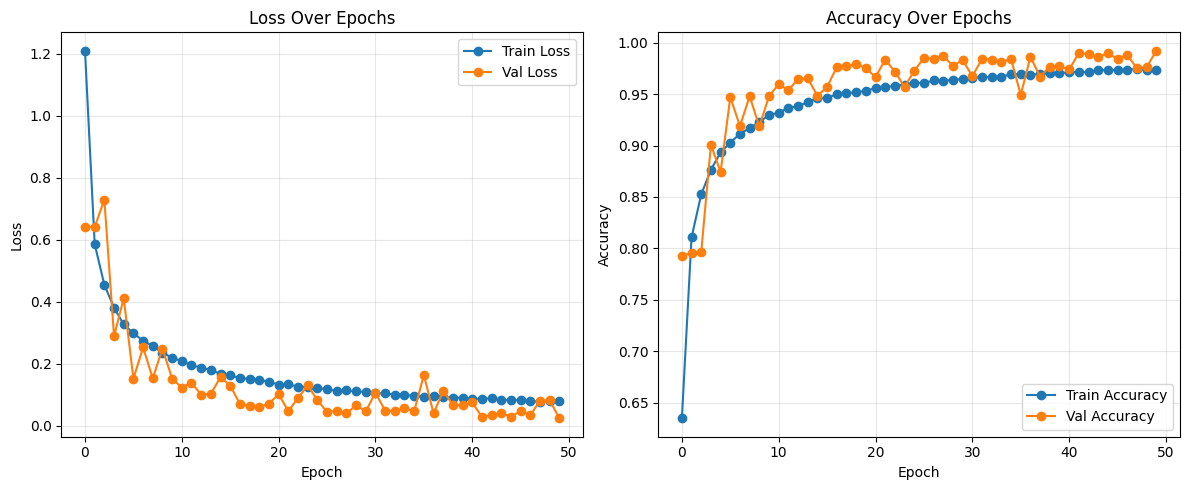

In [28]:

#  Plot Training Graphs

plt.figure(figsize=(12,5))

# 1. Loss Graph

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Val Loss", marker="o")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()


# 2. Accuracy Graph

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy", marker="o")
plt.plot(history["val_acc"], label="Val Accuracy", marker="o")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [29]:

#  Dynamic Quantization (Optional)


from torch.quantization import quantize_dynamic
import torch.nn as nn

# Ensure model is on CPU (required for quantization)
model_cpu = model.to("cpu").eval()

print("Applying dynamic quantization...")


# 1. Apply dynamic quantization (only Linear layers)

quantized_model = quantize_dynamic(
    model_cpu,
    {nn.Linear},       # quantize only the Fully Connected layers
    dtype=torch.qint8  # 8-bit quantization
)

print(" Quantization completed.")


# 2. Script the quantized model and save

quantized_path = r"C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_quantized.pt"

scripted_quantized = torch.jit.script(quantized_model)
scripted_quantized.save(quantized_path)

print(" Quantized TorchScript model saved to:", quantized_path)



Applying dynamic quantization...
 Quantization completed.
 Quantized TorchScript model saved to: C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_quantized.pt


In [30]:
from torch.quantization import quantize_dynamic
import torch.nn as nn
import os

# Ensure model is on CPU
model_cpu = model.to("cpu").eval()

print("Applying dynamic quantization...")

# 1. Apply dynamic quantization (Linear layers only)
quantized_model = quantize_dynamic(
    model_cpu,
    {nn.Linear},
    dtype=torch.qint8
)

print("✅ Quantization completed.")

# 2. Script and save quantized model
quantized_path = r"C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_quantized.pt"

scripted_quantized = torch.jit.script(quantized_model)
scripted_quantized.save(quantized_path)

print("✅ Quantized model saved to:", quantized_path)

# ---------------------------
# 3. Check & print file size
# ---------------------------
file_size_bytes = os.path.getsize(quantized_path)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024

print("\n📦 Quantized Model Size:")
print(f"• {file_size_bytes:,} bytes")
print(f"• {file_size_kb:.2f} KB")
print(f"• {file_size_mb:.2f} MB")

Applying dynamic quantization...
✅ Quantization completed.
✅ Quantized model saved to: C:\Users\AL IMRAN\Desktop\cse499_data2\leaf_cnn_quantized.pt

📦 Quantized Model Size:
• 3,586,116 bytes
• 3502.07 KB
• 3.42 MB
